# Import Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Euclidean distance function

In [2]:
def compute_euclidean_distance_matrix(locations):
    """
    Compute Euclidean distance matrix for a list of locations.
    Args:
        locations: numpy array or list of shape (N, 2), with [x, y] coordinates for each node (depot + customers)
    Returns:
        distance_matrix: numpy array of shape (N, N) where (i, j) is the distance between node i and j
    """
    locations = np.array(locations)
    diff = locations[:, np.newaxis, :] - locations[np.newaxis, :, :]
    distance_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    return distance_matrix


# Example usage:
# Suppose depot at (0,0), customer1 at (2,3), customer2 at (3,1), customer3 at (5,5)
locations = [
    [0, 0],  # Depot
    [2, 3],  # Customer 1
    [3, 1],  # Customer 2
    [5, 5],  # Customer 3
]
dist_matrix = compute_euclidean_distance_matrix(locations)
print(dist_matrix)

[[0.         3.60555128 3.16227766 7.07106781]
 [3.60555128 0.         2.23606798 3.60555128]
 [3.16227766 2.23606798 0.         4.47213595]
 [7.07106781 3.60555128 4.47213595 0.        ]]


# Import Data

In [3]:
# Load CSV files
df_customers = pd.read_excel(
    r"C:\rl-meta-test\src\Source\Solomon datasets\c101.xlsx", sheet_name="customer"
)
df_dataInfo = pd.read_excel(
    r"C:\rl-meta-test\src\Source\Solomon datasets\c101.xlsx", sheet_name="vehicle"
)

# Data Preparation

In [4]:
Customer_25 = 10
# Extract coordinates (x, y) of customers (including depot) and convert to NumPy array
xycoord = df_customers.iloc[:Customer_25, 1:3].to_numpy()
distance = compute_euclidean_distance_matrix(xycoord)  # Calculate distance
# distance = pd.read_csv(
#    r"C:\rl-meta-test\src\Source\solomon_data\solomon25_csv\distance_matrix\c101distanceMatrix.csv"
# ).to_numpy()


# Extract demand for each customer as NumPy array
demand = df_customers.iloc[:Customer_25, 3].to_numpy()

# Extract 'ready time' (earliest time service can begin at each customer)
readyTime = df_customers.iloc[:Customer_25, 4].to_numpy()

# Extract 'due date' (latest time service must begin at each customer)
dueDate = df_customers.iloc[:Customer_25, 5].to_numpy()

# Extract service time required at each customer
serviceTime = df_customers.iloc[:Customer_25, 6].to_numpy()

# Extract vehicle information (such as capacity, number of vehicles, etc.) from the first row of df_dataInfo
vehicle = df_dataInfo.iloc[0, :].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}


In [5]:
distance

array([[ 0.        , 18.68154169, 20.61552813, 16.1245155 , 18.11077028,
        15.13274595, 19.        , 16.        , 18.11077028, 20.09975124],
       [18.68154169,  0.        ,  2.        ,  3.60555128,  3.        ,
         4.24264069,  5.09901951,  5.38516481,  7.        ,  7.28010989],
       [20.61552813,  2.        ,  0.        ,  5.        ,  3.60555128,
         5.83095189,  5.09901951,  6.40312424,  7.28010989,  7.        ],
       [16.1245155 ,  3.60555128,  5.        ,  0.        ,  2.        ,
         1.        ,  3.60555128,  2.        ,  4.47213595,  5.65685425],
       [18.11077028,  3.        ,  3.60555128,  2.        ,  0.        ,
         3.        ,  2.23606798,  2.82842712,  4.        ,  4.47213595],
       [15.13274595,  4.24264069,  5.83095189,  1.        ,  3.        ,
         0.        ,  4.47213595,  2.23606798,  5.        ,  6.40312424],
       [19.        ,  5.09901951,  5.09901951,  3.60555128,  2.23606798,
         4.47213595,  0.        ,  3.        

# Differential Evolutional Algorithm Parameters

In [6]:
dimensions = len(distance) - 1 + vehicle[0]
maxiters = 1000
n_pop = 100
bounds = np.array([[0, 1]] * dimensions)
Mutation_rate = np.array([0.9, 0.5])
Crossover_rate = np.array([0.5, 0.1])

# Differential Evolutional Algorithm


In [7]:
def differential_evolution(
    objective_func,
    bounds,
    population_size=n_pop,
    max_generations=maxiters,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    **kwargs,
):
    # Initialize population
    population = np.random.uniform(
        bounds[:, 0], bounds[:, 1], (population_size, len(bounds))
    )
    global_solution = np.array([])
    Upperbound_Mutation = Mutation_rate[1]
    Lowerbound_Mutation = Mutation_rate[0]
    Upperbound_Crossover_rate = Crossover_rate[1]
    Lowerbound_Crossover_rate = Crossover_rate[0]
    F = Mutation_rate[0]
    CR = Crossover_rate[0]

    for generation in range(max_generations):
        # print(f'Iteration {generation}')
        current_cost = np.array([])
        F += (Upperbound_Mutation - Lowerbound_Mutation) / max_generations
        CR += (Upperbound_Crossover_rate - Lowerbound_Crossover_rate) / max_generations
        for i in range(population_size):
            # Mutation
            indices = [idx for idx in range(population_size) if idx != i]
            a, b, c = population[np.random.choice(indices, 3, replace=False)]
            mutant = population[i] + F * (b - c)

            # Crossover
            crossover_prob = np.random.rand(len(bounds))
            trial = np.where(crossover_prob < CR, mutant, population[i])

            # Selection
            fitness_trial = objective_func(trial, **kwargs)
            fitness_current = objective_func(population[i], **kwargs)

            if fitness_trial < fitness_current:
                population[i] = trial
                current_cost = np.insert(current_cost, len(current_cost), fitness_trial)
            else:
                current_cost = np.insert(
                    current_cost, len(current_cost), fitness_current
                )

        best_index_plot = current_cost[np.argmin(current_cost)]
        global_solution = np.insert(
            global_solution, len(global_solution), best_index_plot
        )

    # Find the best solution
    best_index = np.argmin(
        [objective_func(individual, **kwargs) for individual in population]
    )
    best_solution = population[best_index]

    return best_solution, global_solution

# Decoding

In [8]:
def objective_func(x, **kwargs):
    vehicle = kwargs["vehicle"]
    seq = x[: -vehicle[0]].argsort() + 1
    sort = x[-vehicle[0] :].argsort()
    j = f_per_particle(
        seq, sort, **kwargs
    )  # [f_per_particle1(x[i], sort[i], i, **kwargs) if i <= 2 else f_per_particle(x[i], sort[i], **kwargs) for i in range(n_particles)]        # Calculate each particle.
    return np.array(j)


def f_per_particle(m, s, **kwargs):
    X = m  # Sequence
    V = s  # Vehicle
    obj_val = preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
    return obj_val

def preserving_strategy(X, V, **kwargs):
    # --- Unpack input data from keyword arguments ---
    dist = kwargs["distance"]            # Distance/time matrix between all nodes
    weight = kwargs["demand"]            # Demand (weight) for each customer node
    ready = kwargs["readyTime"]          # Ready time (earliest service time) for each node
    due = kwargs["dueDate"]              # Due time (latest service time) for each node
    service = kwargs["serviceTime"]      # Service time at each node
    vehicle = kwargs["vehicle"]          # Vehicle info: [number of vehicles, capacity per vehicle]
    # Get per-vehicle capacities (by indexing with V)
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]

    # -- Initialization --
    sequence = X                        # Route sequence (includes depot at start & end)
    n_cust = len(sequence) - 2          # Number of customers (not counting depot nodes)
    n_veh = vehicle[0] - 1              # Number of vehicles - 1 (for indexing)
    i, k = 0, 0                         # i: current position in sequence, k: vehicle index
    total_distance = 0                  # Store total traveled distance (with penalty if any)

    # -- Main loop over each vehicle route --
    while k <= n_veh and i <= n_cust:
        # Initialize per-route accumulators
        route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

        if k > 0:
            i += 1   # Move to the next start customer for the next vehicle
        # Start route: depot to first customer
        route_dist += dist[0][sequence[i]]                           # Distance depot -> first customer
        route_time += service[0] + dist[0][sequence[i]]              # Service + travel time to first customer
        weight_load += weight[sequence[i]]                           # Initial cargo: first customer demand

        if route_time < ready[sequence[i]]:
            route_time = ready[sequence[i]]  # Wait if vehicle arrives before ready time

        if route_time > due[sequence[i]]:
            penaltyCost += 1e11              # Penalty: arrived after due time (infeasible)
            break

        # --- Continue visiting customers along this route ---
        while i <= n_cust:
            route_dist += dist[sequence[i]][sequence[i + 1]]                       # Add next leg distance
            route_time += service[sequence[i]] + dist[sequence[i]][sequence[i + 1]] # Add service + travel time
            weight_load += weight[sequence[i + 1]]                                 # Add new customer demand

            if route_time < ready[sequence[i+1]]:
                route_time = ready[sequence[i+1]]  # Wait if arrive early at next node

            # If time window or capacity violated, backtrack and finish route
            if route_time > due[sequence[i+1]] or weight_load > w_cap[k]:
                route_dist -= dist[sequence[i]][sequence[i + 1]]
                route_time -= service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                weight_load -= weight[sequence[i + 1]]
                break
            i += 1

        # --- Finish by returning to depot ---
        route_dist += dist[sequence[i]][0]                    # Add distance to depot
        route_time += service[sequence[i]] + dist[sequence[i]][0]  # Add service at last node + travel to depot
        if route_time > due[0]: 
            penaltyCost += 1e11                               # Penalty: returned to depot too late
        # Accumulate this route's total (distance + penalty if any)
        total_distance += route_dist + penaltyCost
        #print(f'Total weight {weight_load} km.')
        #print(f'Traveling time {route_time} mins.')
        #print(f'Total traveling distance {route_dist} km.')
        k += 1                                                # Next vehicle

    return total_distance                                     # Return overall objective (distance with penalty if violated)


# Finding Solution


In [10]:
start_algorithm = time.time()
best_solution, global_solution_plot = differential_evolution(
    objective_func,
    bounds=bounds,
    population_size=n_pop,
    max_generations=maxiters,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    **kwargs,
)
End_algorithm = time.time()
run_algorithm = End_algorithm - start_algorithm

# Report

In [11]:
def show_preserving_solution(X, V, **kwargs):
    import numpy as np

    dist = kwargs["distance"]
    weight = kwargs["demand"]
    ready = kwargs["readyTime"]
    due = kwargs["dueDate"]
    service = kwargs["serviceTime"]
    vehicle = kwargs["vehicle"]
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]
    
    sequence = list(X)
    
    # --- Split routes by '0' (depot node) for each vehicle ---
    routes = []
    route = []
    for node in sequence:
        if node == 0:
            if route:
                routes.append([0] + route + [0])
                route = []
        else:
            route.append(node)
    if route:  # In case last route has no final depot
        routes.append([0] + route + [0])

    total_distance = 0
    total_time = 0
    max_loading = 0

    for k, route_nodes in enumerate(routes):
        # Prepare for print
        loading_list = [0]      # At depot: load = 0
        visited_time = [0]      # time at depot = 0
        distance_list = [0]
        
        feasible = True

        route_dist = 0
        route_time = 0
        weight_load = 0
        
        for idx in range(1, len(route_nodes)):
            prev, curr = route_nodes[idx-1], route_nodes[idx]
            route_dist += dist[prev][curr]
            route_time += service[prev] + dist[prev][curr]
            # For depot, weight = 0; For other node, add demand
            if curr != 0:
                weight_load += weight[curr]
                route_time = max(route_time, ready[curr])
            else:
                weight_load = 0  # When return to depot, unloading

            loading_list.append(weight_load)
            visited_time.append(route_time)
            distance_list.append(route_dist)

            # Feasibility check
            if curr != 0:
                if (route_time > due[curr]) or (weight_load > w_cap[k]):
                    feasible = False

        # After finished route for this vehicle, print
        print(f"\n=== Vehicle {k+1} ===")
        print("Idx\tNode\tLoad\t(Cap)\tArrTime\t[TimeWin]\tDistFromDepot\tLoad_OK\tTime_OK")
        for idx in range(len(route_nodes)):
            node = route_nodes[idx]
            load_ok = loading_list[idx] <= w_cap[k]
            time_ok = ready[node] <= visited_time[idx] <= due[node]
            print(f"{idx:>3}\t{node:>4}\t{loading_list[idx]:>5.2f}\t/{w_cap[k]:>4}\t"
                  f"{visited_time[idx]:>6.2f}\t[{ready[node]}, {due[node]}]\t"
                  f"{distance_list[idx]:>10.2f}\t"
                  f"{'✔' if load_ok else '✘'}\t{'✔' if time_ok else '✘'}")
        print(f"\nRoute: {' → '.join(map(str, route_nodes))}")
        print(f"Feasible: {'Yes' if feasible else 'No'}")
        print(f"Total route distance: {route_dist:.2f} km")
        print(f"Total route time: {route_time:.2f} min")
        print(f"Max loading: {max(loading_list):.2f} / capacity {w_cap[k]}")

        total_distance += route_dist
        total_time += route_time
        max_loading = max(max_loading, max(loading_list))

    # --- SUMMARY ---
    print("\n========= SUMMARY ==========")
    print(f"Total fleet distance  : {total_distance:.2f} km")
    print(f"Total fleet travel time: {total_time:.2f} min")
    print(f"Max vehicle loading   : {max_loading:.2f} kg")
    print("===========================")

In [12]:
seq = best_solution[: -vehicle[0]].argsort() + 1
sort = best_solution[-vehicle[0] :].argsort()

In [ ]:
preserving_strategy(seq, sort, **kwargs)

np.float64(116.85236574369442)

In [13]:
show_preserving_solution(seq, sort, **kwargs)



=== Vehicle 1 ===
Idx	Node	Load	(Cap)	ArrTime	[TimeWin]	DistFromDepot	Load_OK	Time_OK
  0	   0	 0.00	/200.0	  0.00	[0, 1236]	      0.00	✔	✔
  1	   5	10.00	/200.0	 15.13	[15, 67]	     15.13	✔	✔
  2	   3	20.00	/200.0	106.13	[65, 146]	     16.13	✔	✔
  3	   7	40.00	/200.0	198.13	[170, 225]	     18.13	✔	✔
  4	   8	60.00	/200.0	290.96	[255, 324]	     20.96	✔	✔
  5	   9	70.00	/200.0	534.00	[534, 605]	     22.96	✔	✔
  6	   6	90.00	/200.0	626.24	[621, 702]	     25.20	✔	✔
  7	   4	100.00	/200.0	727.00	[727, 782]	     27.43	✔	✔
  8	   2	130.00	/200.0	825.00	[825, 870]	     31.04	✔	✔
  9	   1	140.00	/200.0	917.00	[912, 967]	     33.04	✔	✔
 10	   0	 0.00	/200.0	1025.68	[0, 1236]	     51.72	✔	✔

Route: 0 → 5 → 3 → 7 → 8 → 9 → 6 → 4 → 2 → 1 → 0
Feasible: Yes
Total route distance: 51.72 km
Total route time: 1025.68 min
Max loading: 140.00 / capacity 200.0

========= SUMMARY ==========
Total fleet distance  : 51.72 km
Total fleet travel time: 1025.68 min
Max vehicle loading   : 140.00 kg


# Plotting

In [ ]:
demand

array([ 0, 10, 30, 10, 10, 10, 20, 20, 20, 10])

In [ ]:
y1[-1]

NameError: name 'y1' is not defined

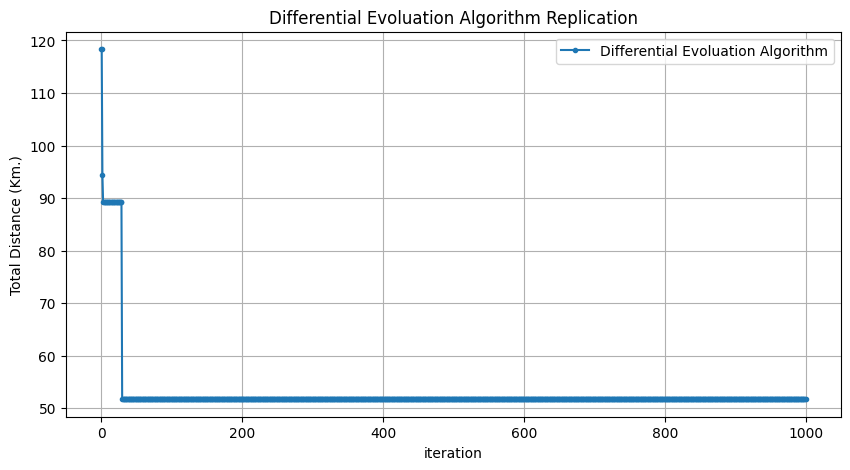

In [14]:
Replication = [i for i in range(len(global_solution_plot))]
y1 = global_solution_plot.tolist()
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(Replication, y1, marker=".", label="Differential Evoluation Algorithm")
ax.set(
    xlabel="iteration",
    ylabel="Total Distance (Km.)",
    title="Differential Evoluation Algorithm Replication",
)
ax.grid()
ax.legend()
plt.show()